# Define the sample of proto-MW/Heracles stars to do the fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import cmasher as cm
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

print(len(data))

554777


# Define the parent sample, and remove all stars belonging to GCs, MCs, etc

In [3]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE VAC DATA FOR THE GCs in APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_members_VAC.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7260 GC stars


In [4]:
apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [5]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()


526130

In [6]:
aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [7]:
# get the SGR stars from Horta et al 2023
loadpath =  '/Users/dhortadarrington/Documents/Projects/accreted-systems/sav/paper/'
mask_sgr = np.load(loadpath+'mask_sgr.npy')

# Remove the MCs
lmc_ids = np.loadtxt('/Users/dhortadarrington/Documents/Master/data/LMC_ID_final.txt',dtype='str')
smc_ids = np.loadtxt('/Users/dhortadarrington/Documents/Master/data/SMC_ID_final.txt',dtype='str')
lmc_id = np.isin(list(data['APOGEE_ID']),list(lmc_ids))
smc_id = np.isin(list(data['APOGEE_ID']),list(smc_ids))


In [15]:
dist = data['dist50']
dist_err = (data['dist84'] - data['dist16'])/2.

# create the parent mask
mask = (data['SNR']>70)&(data['LOGG']<3.5)&(data['TEFF']>4000.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['EXTRATARG']==0)\
    &(dist/dist_err>10.)
# &(data['AL_FE_FLAG']==0)&(data['MG_FE_FLAG']==0)&(data['MN_FE_FLAG']==0)

print('There are '+str(len(data[mask]))+' stars in the parent sample')

There are 156021 stars in the parent sample


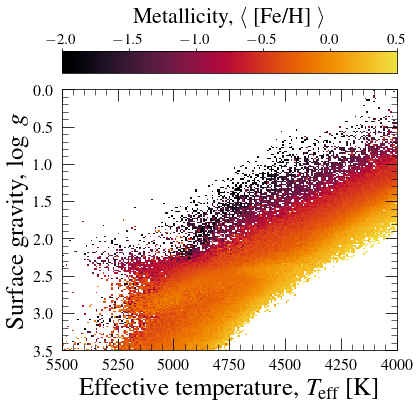

In [36]:
# plot the Kiel diagram
from scipy import stats


fig = plt.figure(figsize=(6,6), facecolor='white')
nbins = 200
binx = np.linspace(np.min(data['TEFF'][mask]),np.max(data['TEFF'][mask]),nbins)
biny = np.linspace(np.min(data['LOGG'][mask]),np.max(data['LOGG'][mask]),nbins)
hist = stats.binned_statistic_2d(data['TEFF'][mask],data['LOGG'][mask], data['FE_H'][mask], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.ember,vmin=-2.,vmax=0.5, rasterized=True)
    
plt.xlabel('Effective temperature, $T_{\mathrm{eff}}$ [K]', fontsize=25)
plt.ylabel('Surface gravity, $\log~g$', fontsize=25)
plt.xlim(5500,4000)
plt.ylim(3.5,0)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=12, pad=8)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True, pad=8)
plt.minorticks_on()

cbar = fig.colorbar(color,  aspect=15,orientation='horizontal',location='top')
cbar.set_label(label=r'Metallicity, $\langle$ [Fe/H] $\rangle$',fontsize=22,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=1)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.savefig('/Users/dhortadarrington/Documents/Projects/halo-density/plots/kiel.pdf',dpi=200, bbox_inches = 'tight')



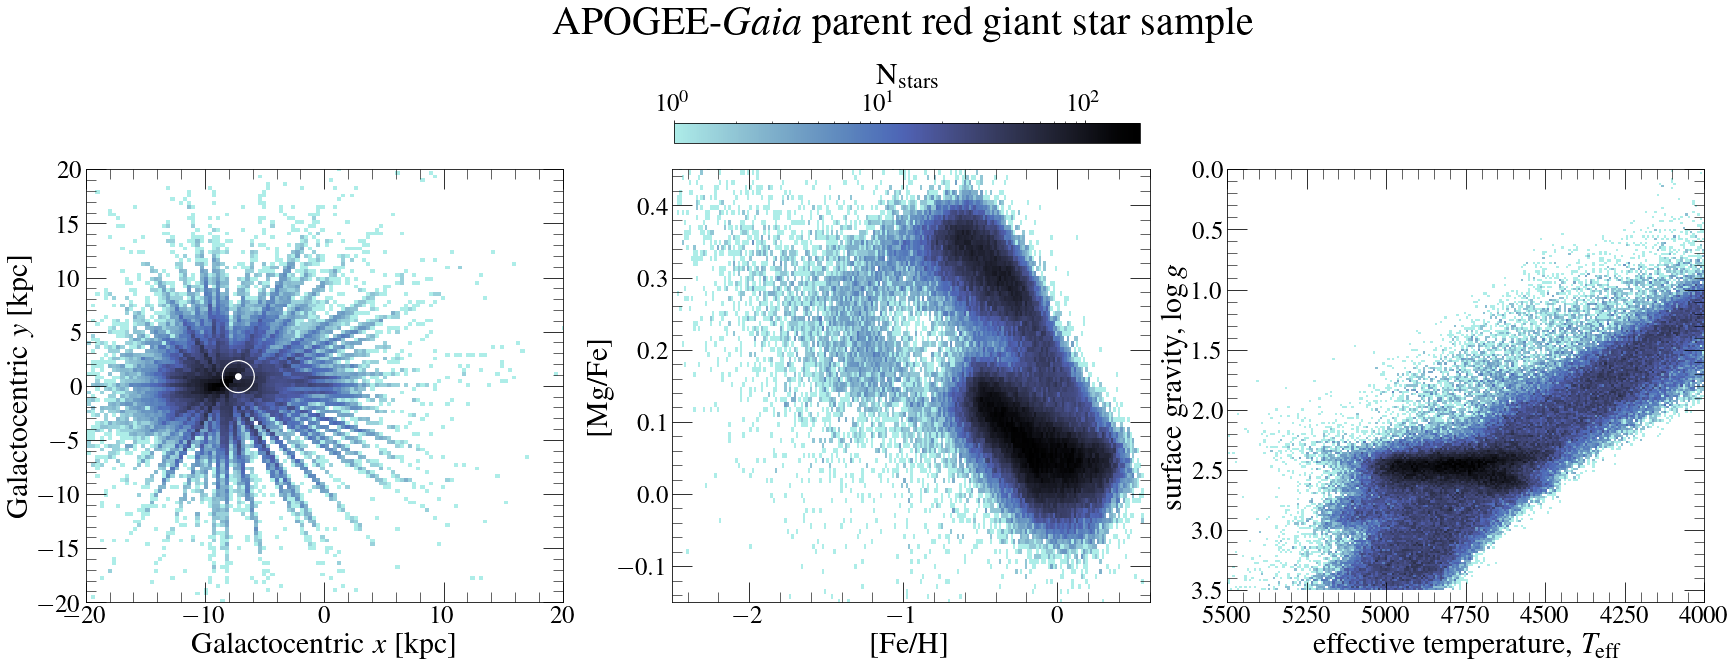

In [10]:
# plot the sample in space

## from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(24,7),constrained_layout=True,facecolor='white')
fig.suptitle('APOGEE-$Gaia$ parent red giant star sample',fontsize=40,x=0.52,y=1.3)

plt.subplot(1,3,1)
plt.hist2d(data['xyz'][:,0][mask],data['xyz'][:,1][mask],bins=300,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
# plt.scatter(-8.125,0.,c='white',s=100)
plt.text(-8.7,-0.35,'$\odot$',fontsize=50,color='white',fontweight='bold')
plt.xlabel('Galactocentric $x$ [kpc]', fontsize=30)
plt.ylabel('Galactocentric $y$ [kpc]', fontsize=30)
plt.xlim(-20,20)
plt.ylim(-20.,20.)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
# plt.title('APOGEE-$Gaia$ parent red giant star sample', fontsize=35, x=0.5,y=1.3)
plt.hist2d(data['FE_H'][mask&(data['FE_H']>-10)&(data['MG_FE']>-10)],data['MG_FE'][mask&(data['FE_H']>-10)&(data['MG_FE']>-10)],bins=200,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
plt.xlabel('[Fe/H]', fontsize=30)
plt.ylabel('[Mg/Fe]', fontsize=30)
plt.xlim(-2.5,0.6)
plt.ylim(-0.15,0.45)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.3875, 1.03, 0.27,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(1,3,3)
plt.hist2d(data['TEFF'][mask],data['LOGG'][mask],bins=200,cmap=cm.sapphire_r,norm=LogNorm(),rasterized=True)
plt.xlabel('effective temperature, $T_{\mathrm{eff}}$', fontsize=30)
plt.ylabel('surface gravity, $\log g$', fontsize=30)
plt.xlim(5500,4000)
plt.ylim(3.6,0)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('/Users/dhortadarrington/Documents/Projects/proto-MW-mass/plots/data.pdf',dpi=250, bbox_inches = 'tight')


# Check the eccentricity distribution of the sample, so we can assess the contamination to the halo from the GES

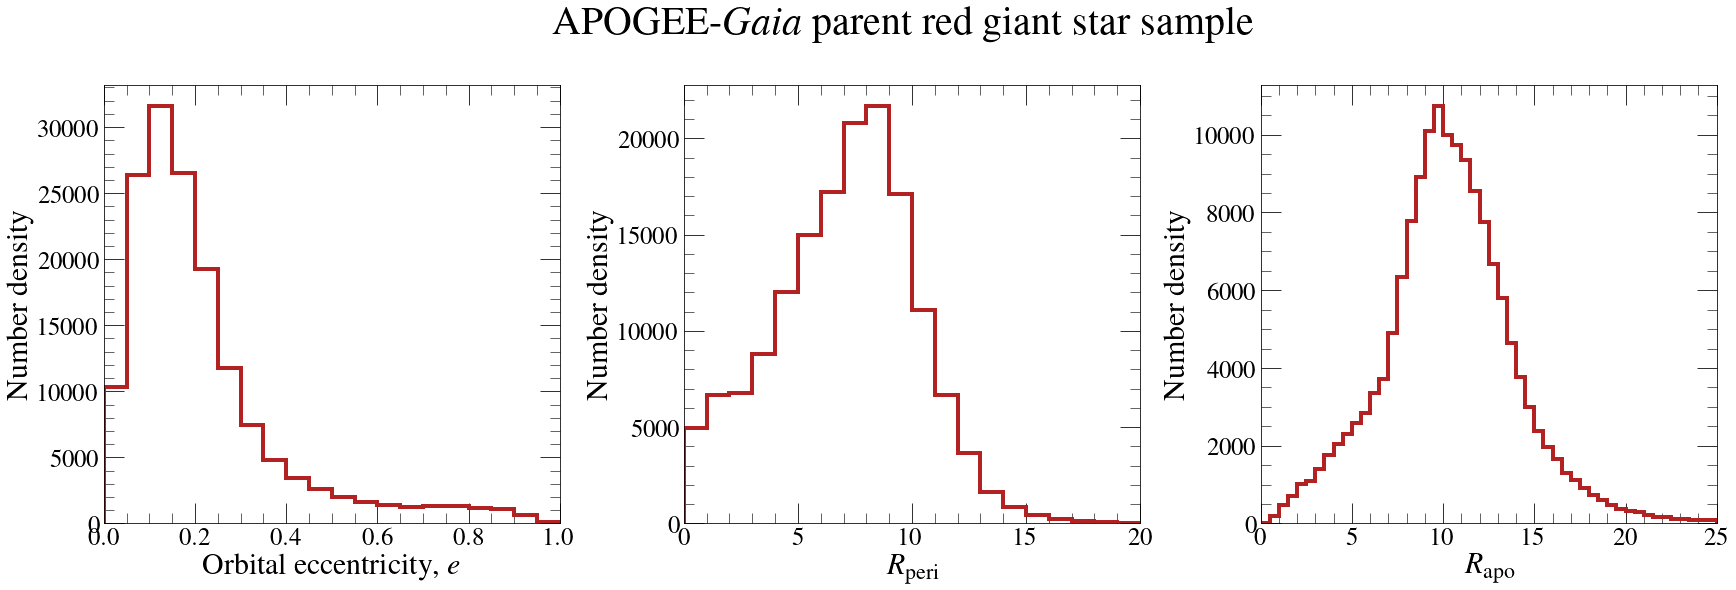

In [11]:
# plot the sample in eccentricity space

fig = plt.figure(figsize=(24,7),constrained_layout=True,facecolor='white')
fig.suptitle('APOGEE-$Gaia$ parent red giant star sample',fontsize=40,x=0.52,y=1.15)

plt.subplot(1,3,1)
plt.hist(data['ecc'][mask],bins=np.linspace(0,1,21),histtype='step', color= 'firebrick', lw=4)
plt.xlabel('Orbital eccentricity, $e$', fontsize=30)
plt.ylabel('Number density', fontsize=30)
plt.xlim(0,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
plt.hist(data['r_per'][mask],bins=np.linspace(0,20,21),histtype='step', color= 'firebrick', lw=4)
plt.xlabel('$R_{\mathrm{peri}}$', fontsize=30)
plt.ylabel('Number density', fontsize=30)
plt.xlim(0,20)
# plt.ylim(0,50)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,3)
plt.hist(data['r_apo'][mask],bins=np.linspace(0,25,51),histtype='step', color= 'firebrick', lw=4)
plt.xlabel('$R_{\mathrm{apo}}$', fontsize=30)
plt.ylabel('Number density', fontsize=30)
plt.xlim(0,25)
# plt.ylim(0,50)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()



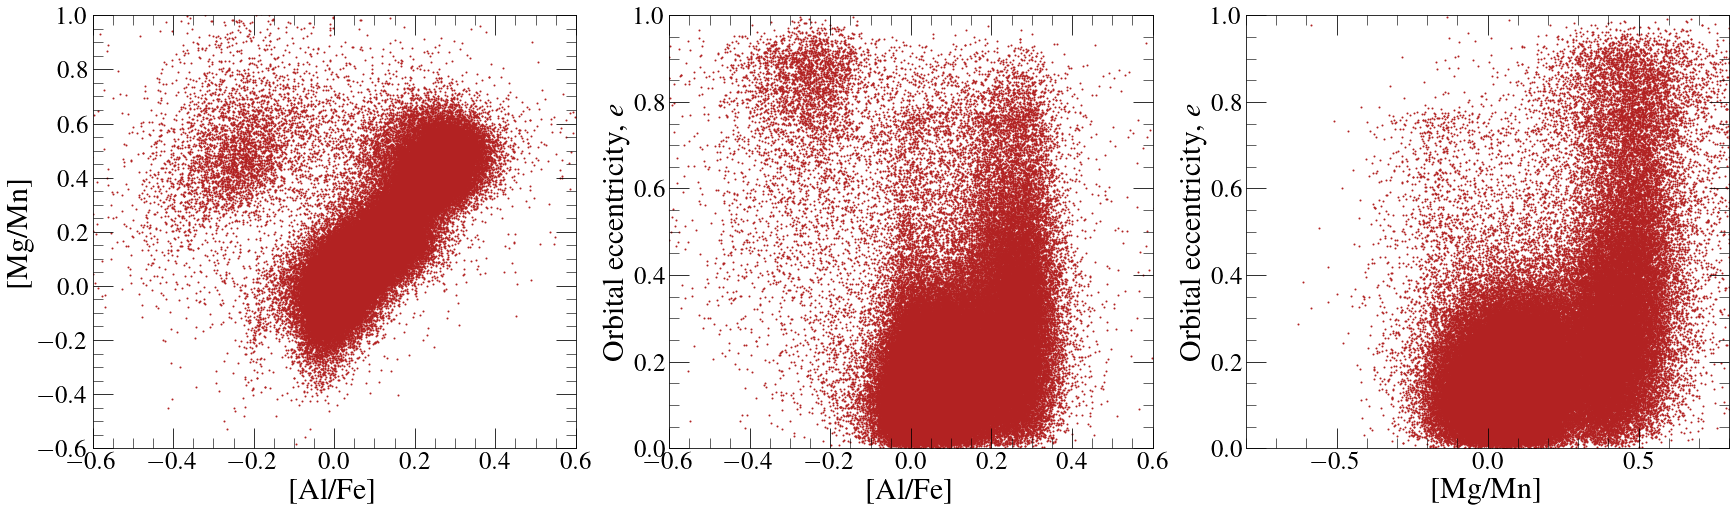

In [12]:
fig = plt.figure(figsize=(24,7),constrained_layout=True,facecolor='white')

mgmn = data['MG_FE'] - data['MN_FE']

plt.subplot(1,3,1)
plt.scatter(data['AL_FE'][mask],mgmn[mask],s=1, color='firebrick')
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
plt.scatter(data['AL_FE'][mask],data['ecc'][mask],s=1, color='firebrick')
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('Orbital eccentricity, $e$', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(0,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,3)
plt.scatter(mgmn[mask],data['ecc'][mask],s=1, color='firebrick')
plt.xlabel('[Mg/Mn]', fontsize=30)
plt.ylabel('Orbital eccentricity, $e$', fontsize=30)
plt.xlim(-0.8,0.8)
plt.ylim(0,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()



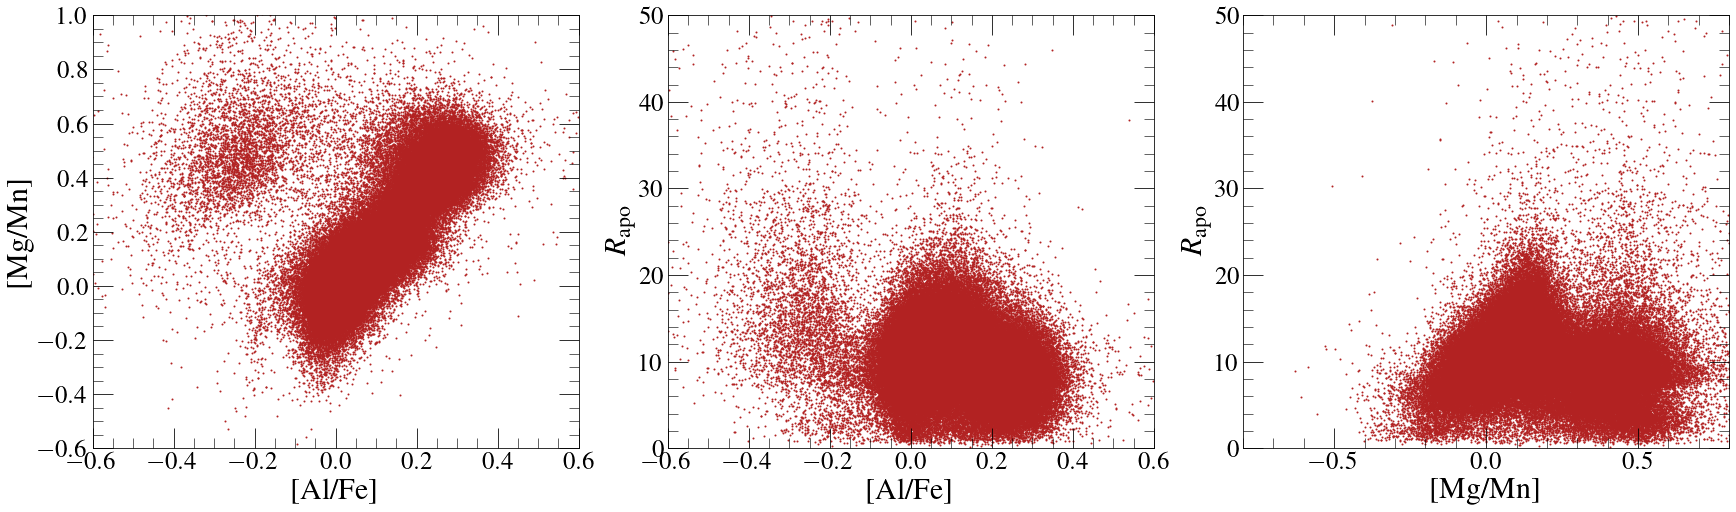

In [13]:
fig = plt.figure(figsize=(24,7),constrained_layout=True,facecolor='white')

mgmn = data['MG_FE'] - data['MN_FE']

plt.subplot(1,3,1)
plt.scatter(data['AL_FE'][mask],mgmn[mask],s=1, color='firebrick')
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,2)
plt.scatter(data['AL_FE'][mask],data['r_apo'][mask],s=1, color='firebrick')
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('$R_{\mathrm{apo}}$', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(0,50)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(1,3,3)
plt.scatter(mgmn[mask],data['r_apo'][mask],s=1, color='firebrick')
plt.xlabel('[Mg/Mn]', fontsize=30)
plt.ylabel('$R_{\mathrm{apo}}$', fontsize=30)
plt.xlim(-0.8,0.8)
plt.ylim(0,50)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()



In [14]:
mask_une = (((mgmn >= 0.1) & (data['AL_FE'] <= -0.2)) |  \
            ((data['AL_FE'] > -0.2) & (mgmn >= 2.*data['AL_FE']+0.5)) )
print(len(data[mask&mask_une]))

4445


In [15]:
np.save('../sav/mask_parent',mask)
np.save('../sav/mask_unevolved',mask_une)

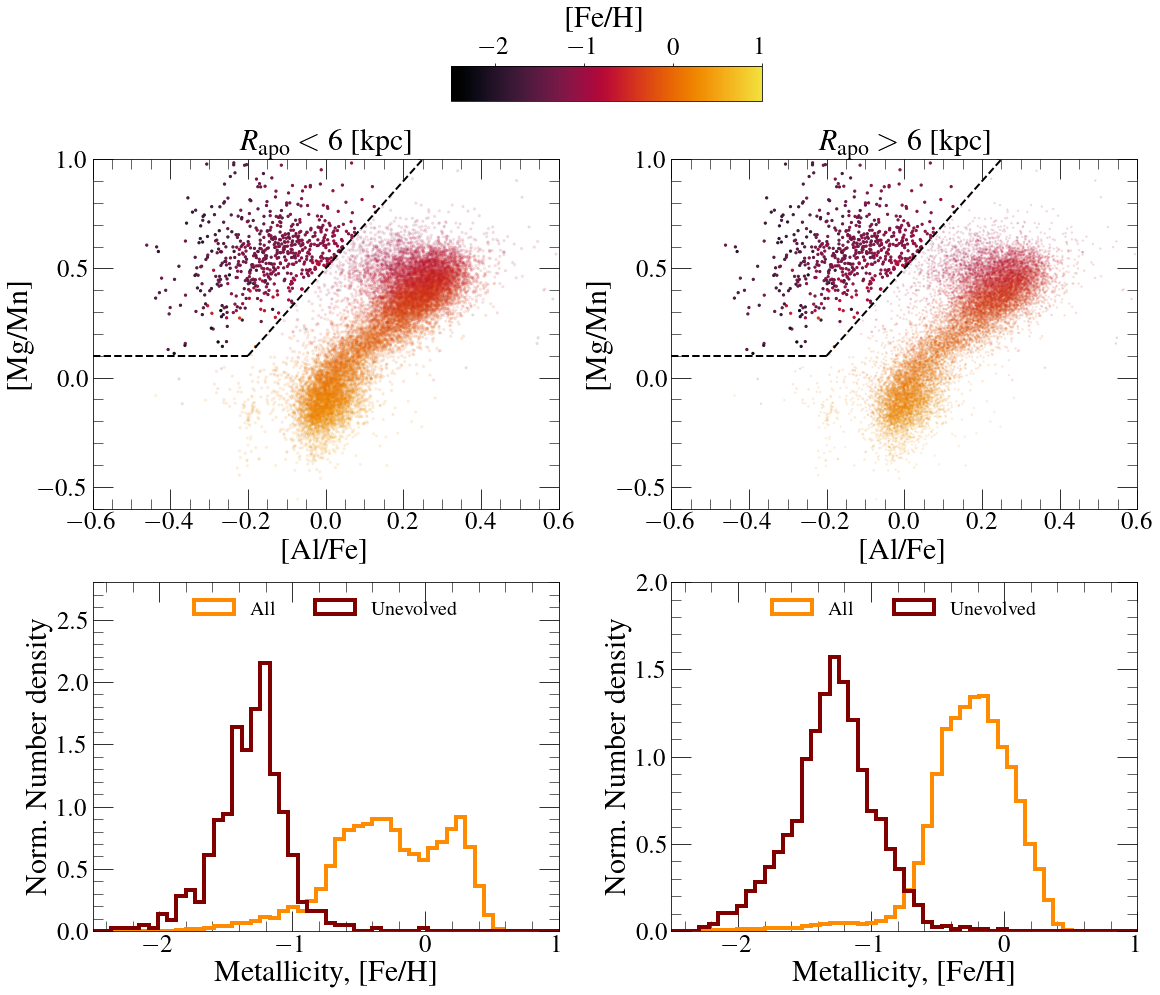

In [16]:
apodist = 6

fig = plt.figure(figsize=(16,12),constrained_layout=True,facecolor='white')

plt.subplot(2,2,1)
plt.title(r'$R_{\mathrm{apo}} <$ '+str(round(apodist,0))+' [kpc]', fontsize=30)
plt.scatter(data['AL_FE'][mask&(data['r_apo']<apodist)],mgmn[mask&(data['r_apo']<apodist)],s=5, c=data['FE_H'][mask&(data['r_apo']<apodist)],\
               cmap=cm.ember, vmin=-2.5,vmax=1, alpha=0.1)
plt.scatter(data['AL_FE'][mask&(data['r_apo']<apodist)&mask_une],mgmn[mask&(data['r_apo']<apodist)&mask_une],s=5, c=data['FE_H'][mask&(data['r_apo']<apodist)&mask_une],\
               cmap=cm.ember, vmin=-2.5,vmax=1, alpha=1)
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.plot([-0.2,0.25], [0.1,1], c='k', lw=2, ls='dashed')
plt.plot([-0.6,-0.2], [0.1,0.1], c='k', lw=2, ls='dashed')


plt.subplot(2,2,2)
plt.title(r'$R_{\mathrm{apo}} >$ '+str(round(apodist,0))+' [kpc]', fontsize=30)
plt.scatter(data['AL_FE'][mask&(data['r_apo']<apodist)],mgmn[mask&(data['r_apo']<apodist)],s=2.5, c=data['FE_H'][mask&(data['r_apo']<apodist)],\
               cmap=cm.ember, vmin=-2.5,vmax=1, alpha=0.1)
color = plt.scatter(data['AL_FE'][mask&(data['r_apo']<apodist)&mask_une],mgmn[mask&(data['r_apo']<apodist)&mask_une],s=5, c=data['FE_H'][mask&(data['r_apo']<apodist)&mask_une],\
               cmap=cm.ember, vmin=-2.5,vmax=1, alpha=1)
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()
plt.plot([-0.2,0.25], [0.1,1], c='k', lw=2, ls='dashed')
plt.plot([-0.6,-0.2], [0.1,0.1], c='k', lw=2, ls='dashed')


cbar_ax = fig.add_axes([0.3875, 1.03, 0.27,0.04])
cb = plt.colorbar(color, cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'[Fe/H]',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')


plt.subplot(2,2,3)
plt.hist(data['FE_H'][mask&(data['r_apo']<apodist)],bins=np.linspace(-2.5,1,51),histtype='step', color= 'darkorange', lw=4, density=True, label='All')
plt.hist(data['FE_H'][mask&(data['r_apo']<apodist)&mask_une],bins=np.linspace(-2.5,1,51),histtype='step', color= 'maroon', lw=4, density=True, label='Unevolved')
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.ylabel('Norm. Number density', fontsize=30)
plt.xlim(-2.5,1)
plt.ylim(0,2.8)
plt.legend(loc='upper center', frameon=False, fontsize=20, ncols=2)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,2,4)
plt.hist(data['FE_H'][mask&(data['r_apo']>apodist)],bins=np.linspace(-2.5,1,51),histtype='step', color= 'darkorange', lw=4, density=True, label='All')
plt.hist(data['FE_H'][mask&(data['r_apo']>apodist)&mask_une],bins=np.linspace(-2.5,1,51),histtype='step', color= 'maroon', lw=4, density=True, label='Unevolved')
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.ylabel('Norm. Number density', fontsize=30)
plt.xlim(-2.5,1)
plt.ylim(0,2)
plt.legend(loc='upper center', frameon=False, fontsize=20, ncols=2)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()



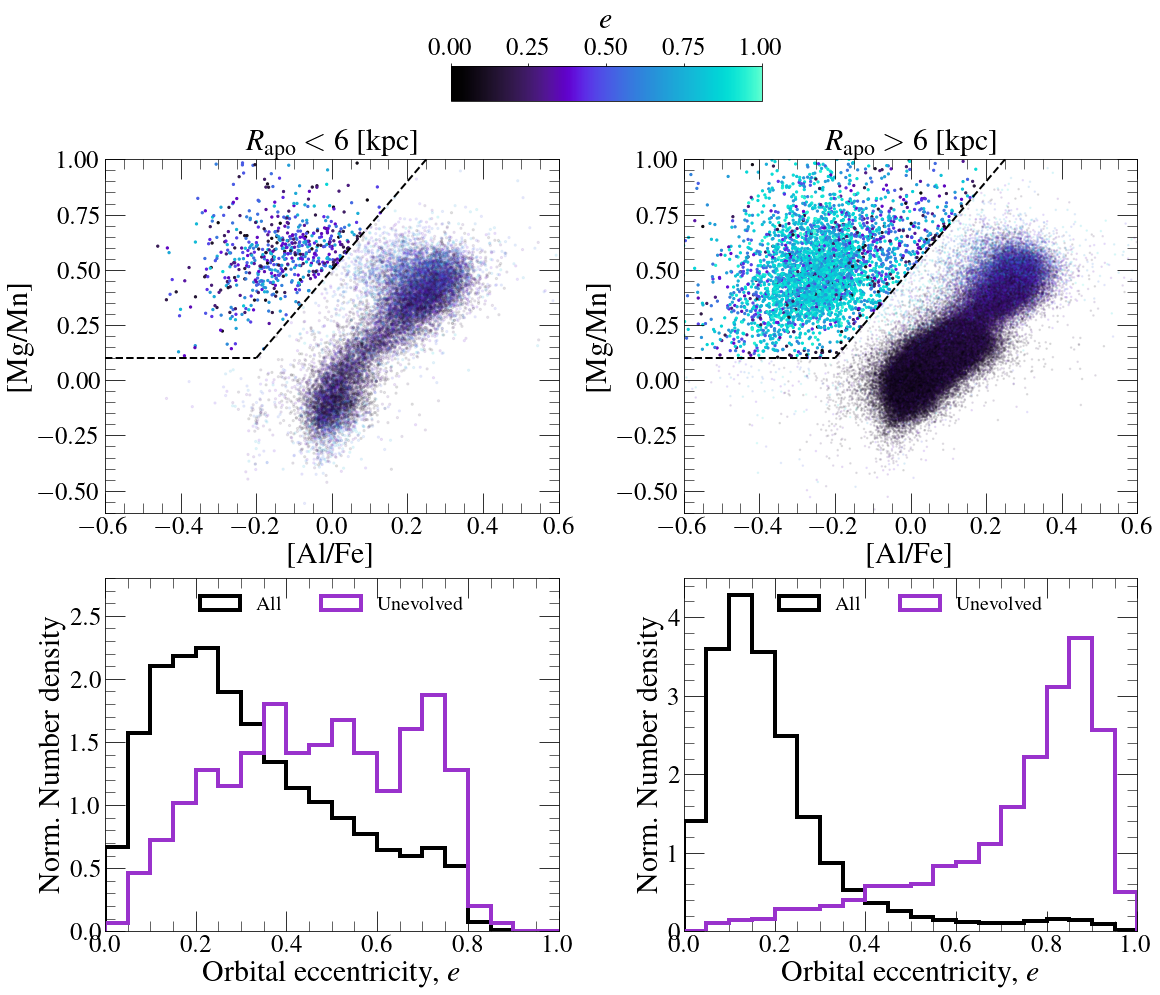

In [194]:

fig = plt.figure(figsize=(16,12),constrained_layout=True,facecolor='white')

plt.subplot(2,2,1)
plt.title(r'$R_{\mathrm{apo}} <$ '+str(round(apodist,0))+' [kpc]', fontsize=30)
plt.scatter(data['AL_FE'][mask&(data['r_apo']<apodist)],mgmn[mask&(data['r_apo']<apodist)],s=5, c=data['ecc'][mask&(data['r_apo']<apodist)],\
               cmap=cm.cosmic, vmin=0,vmax=1, alpha=0.1)
plt.scatter(data['AL_FE'][mask&(data['r_apo']<apodist)&mask_une],mgmn[mask&(data['r_apo']<apodist)&mask_une],s=5, c=data['ecc'][mask&(data['r_apo']<apodist)&mask_une],\
               cmap=cm.cosmic, vmin=0,vmax=1, alpha=1)
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.plot([-0.2,0.25], [0.1,1], c='k', lw=2, ls='dashed')
plt.plot([-0.6,-0.2], [0.1,0.1], c='k', lw=2, ls='dashed')


plt.subplot(2,2,2)
plt.title(r'$R_{\mathrm{apo}} >$ '+str(round(apodist,0))+' [kpc]', fontsize=30)
plt.scatter(data['AL_FE'][mask&(data['r_apo']>apodist)],mgmn[mask&(data['r_apo']>apodist)],s=2.5, c=data['ecc'][mask&(data['r_apo']>apodist)],\
               cmap=cm.cosmic, vmin=0,vmax=1, alpha=0.1)
color = plt.scatter(data['AL_FE'][mask&(data['r_apo']>apodist)&mask_une],mgmn[mask&(data['r_apo']>apodist)&mask_une],s=5, c=data['ecc'][mask&(data['r_apo']>apodist)&mask_une],\
               cmap=cm.cosmic, vmin=0,vmax=1, alpha=1)
plt.xlabel('[Al/Fe]', fontsize=30)
plt.ylabel('[Mg/Mn]', fontsize=30)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,1)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()
plt.plot([-0.2,0.25], [0.1,1], c='k', lw=2, ls='dashed')
plt.plot([-0.6,-0.2], [0.1,0.1], c='k', lw=2, ls='dashed')


cbar_ax = fig.add_axes([0.3875, 1.03, 0.27,0.04])
cb = plt.colorbar(color, cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'$e$',fontsize=30,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplot(2,2,3)
plt.hist(data['ecc'][mask&(data['r_apo']<apodist)],bins=np.linspace(0,1,21),histtype='step', color= 'k', lw=4, density=True, label='All')
plt.hist(data['ecc'][mask&(data['r_apo']<apodist)&mask_une],bins=np.linspace(0,1,21),histtype='step', color= 'darkorchid', lw=4, density=True, label='Unevolved')
plt.xlabel('Orbital eccentricity, $e$', fontsize=30)
plt.ylabel('Norm. Number density', fontsize=30)
plt.xlim(0,1)
plt.ylim(0,2.8)
plt.legend(loc='upper center', frameon=False, fontsize=20, ncols=2)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,2,4)
plt.hist(data['ecc'][mask&(data['r_apo']>apodist)],bins=np.linspace(0,1,21),histtype='step', color= 'k', lw=4, density=True, label='All')
plt.hist(data['ecc'][mask&(data['r_apo']>apodist)&mask_une],bins=np.linspace(0,1,21),histtype='step', color= 'darkorchid', lw=4, density=True, label='Unevolved')
plt.xlabel('Orbital eccentricity, $e$', fontsize=30)
plt.ylabel('Norm. Number density', fontsize=30)
plt.xlim(0,1)
plt.legend(loc='upper center', frameon=False, fontsize=20, ncols=2)
plt.tick_params(which='major',labelsize=25,direction='in',top=True,right=True,length=20)
plt.tick_params(which='minor', length=10, direction='in',top=True,right=True)
plt.minorticks_on()


Text(0, 0.5, '[Mg/Mn]')

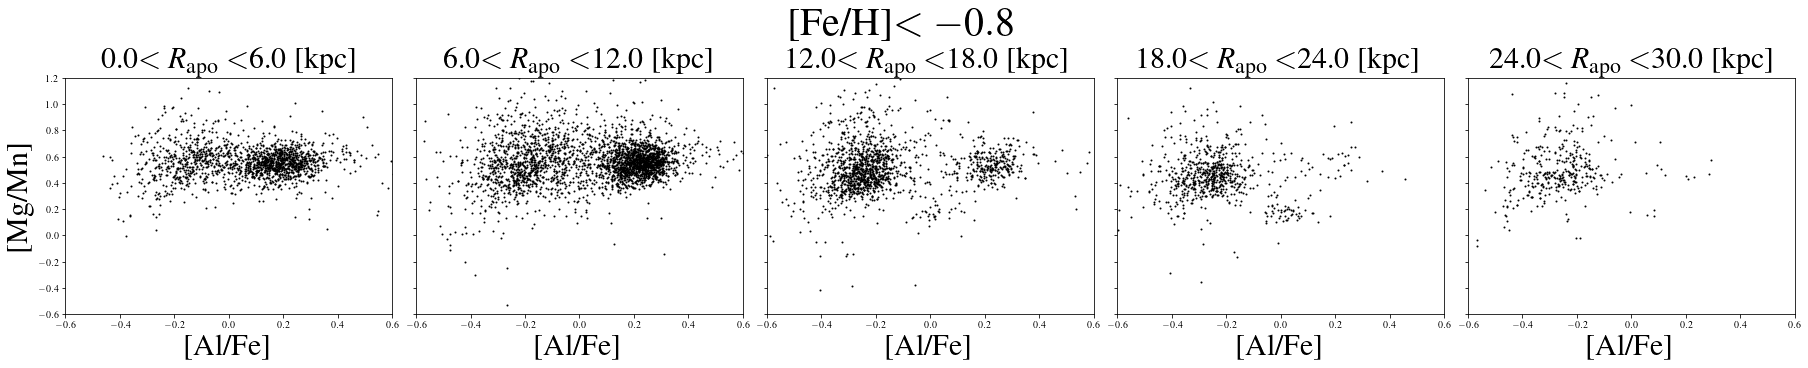

In [195]:
radios = np.linspace(0,30,6)

fig, all_axes = plt.subplots(1,5, constrained_layout=True, figsize=(25, 5), sharex=True, sharey=True,rasterized=True)
fig.suptitle('[Fe/H]$<-0.8$',fontsize=40)

for indx, i in enumerate(radios[:-1]):
    m = (data['r_apo']>i)&(data['r_apo']<radios[indx+1])&(data['FE_H']<-0.8)
    all_axes[indx].set_title(str(i)+r'$<R_{\mathrm{apo}}<$'+str(radios[indx+1])+' [kpc]',fontsize=30)    
    all_axes[indx].scatter(data['AL_FE'][mask&m],mgmn[mask&m],color='k',s=1)
    all_axes[indx].set_xlabel('[Al/Fe]',fontsize=30)
    all_axes[indx].set_xlim(-0.6,0.6)
    all_axes[indx].set_ylim(-0.6,1.2)
    
    
all_axes[0].set_ylabel('[Mg/Mn]',fontsize=30)

Text(0, 0.5, '$z$')

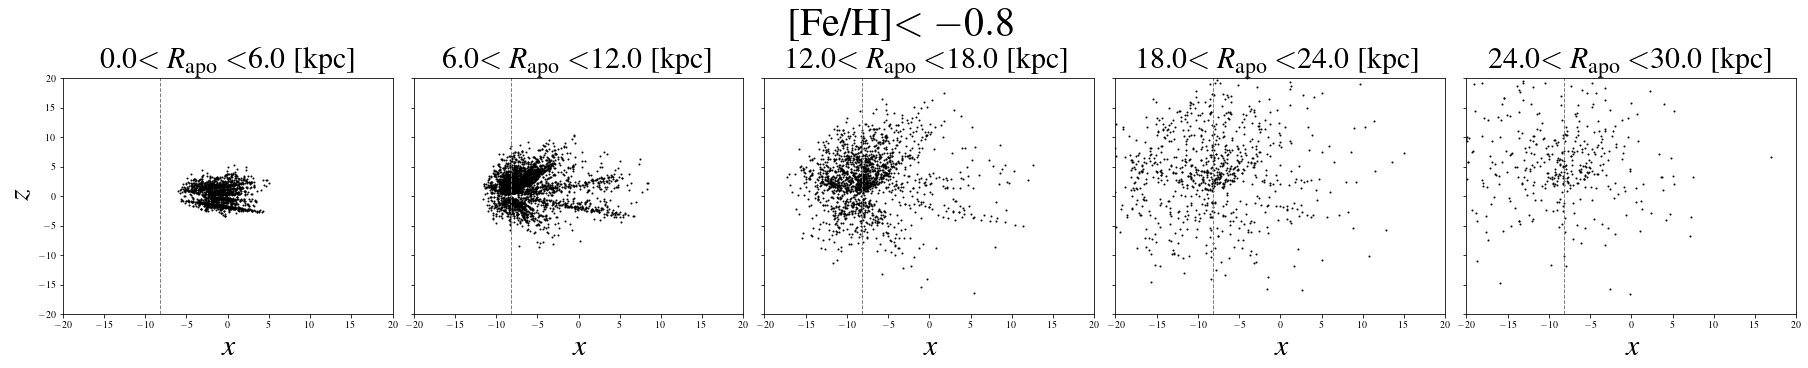

In [196]:
radios = np.linspace(0,30,6)

fig, all_axes = plt.subplots(1,5, constrained_layout=True, figsize=(25, 5), sharex=True, sharey=True,rasterized=True)
fig.suptitle('[Fe/H]$<-0.8$',fontsize=40)

for indx, i in enumerate(radios[:-1]):
    m = (data['r_apo']>i)&(data['r_apo']<radios[indx+1])&(data['FE_H']<-0.8)
    all_axes[indx].set_title(str(i)+r'$<R_{\mathrm{apo}}<$'+str(radios[indx+1])+' [kpc]',fontsize=30)    
    all_axes[indx].scatter(data['xyz'][:,0][mask&m],data['xyz'][:,2][mask&m],color='k',s=1)
    all_axes[indx].set_xlabel('$x$',fontsize=30)
    all_axes[indx].set_xlim(-20,20)
    all_axes[indx].set_ylim(-20,20)
    all_axes[indx].plot([-8.2,-8.2],[-20,20], c='gray', ls='--', lw=1)
    
all_axes[0].set_ylabel('$z$',fontsize=30)

Text(0, 0.5, '$y$')

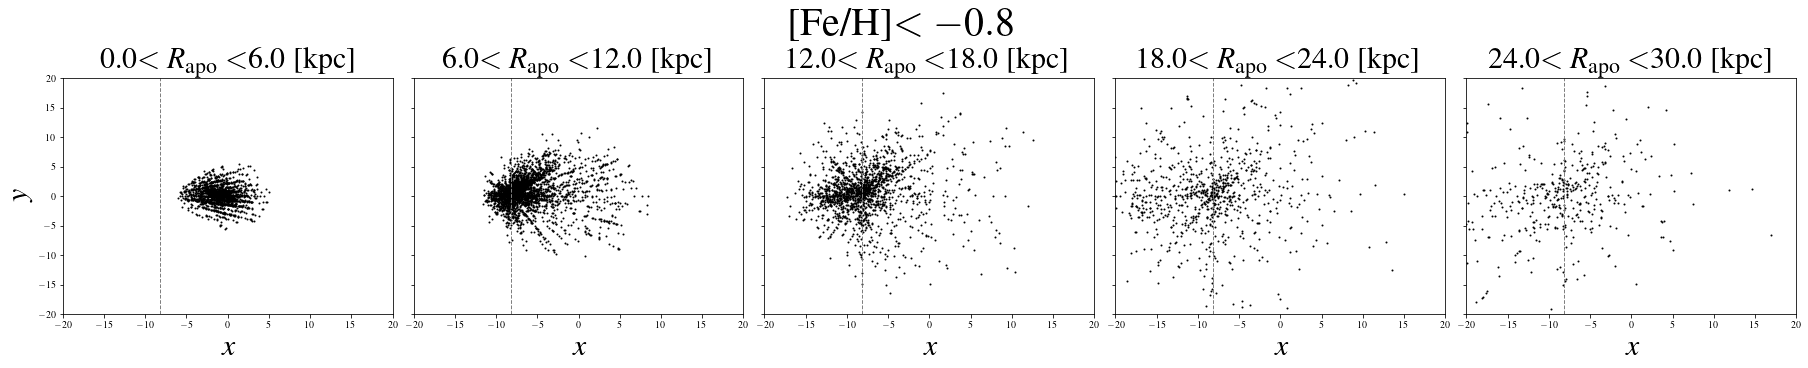

In [197]:
radios = np.linspace(0,30,6)

fig, all_axes = plt.subplots(1,5, constrained_layout=True, figsize=(25, 5), sharex=True, sharey=True,rasterized=True)
fig.suptitle('[Fe/H]$<-0.8$',fontsize=40)

for indx, i in enumerate(radios[:-1]):
    m = (data['r_apo']>i)&(data['r_apo']<radios[indx+1])&(data['FE_H']<-0.8)
    all_axes[indx].set_title(str(i)+r'$<R_{\mathrm{apo}}<$'+str(radios[indx+1])+' [kpc]',fontsize=30)    
    all_axes[indx].scatter(data['xyz'][:,0][mask&m],data['xyz'][:,1][mask&m],color='k',s=1)
    all_axes[indx].set_xlabel('$x$',fontsize=30)
    all_axes[indx].plot([-8.2,-8.2],[-20,20], c='gray', ls='--', lw=1)
    all_axes[indx].set_xlim(-20,20)
    all_axes[indx].set_ylim(-20,20)
    
    
all_axes[0].set_ylabel('$y$',fontsize=30)

Text(0, 0.5, 'Density')

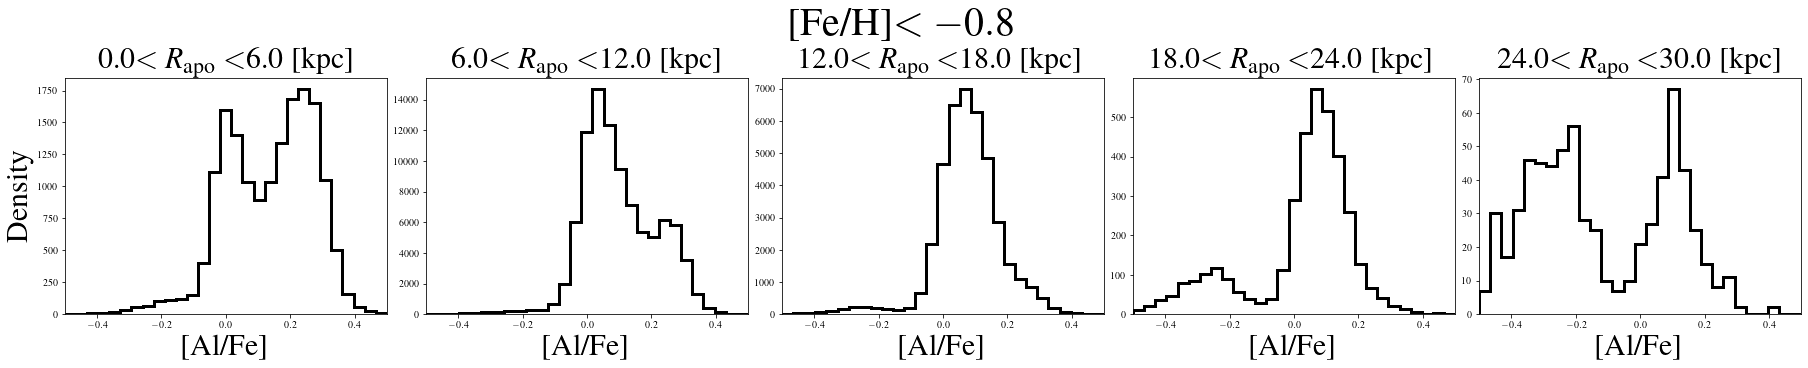

In [198]:
fig, all_axes = plt.subplots(1,5, constrained_layout=True, figsize=(25, 5), sharex=True, rasterized=True, facecolor='white')
fig.suptitle('[Fe/H]$<-0.8$',fontsize=40)

for indx, i in enumerate(radios[:-1]):
    m = (data['r_apo']>i)&(data['r_apo']<radios[indx+1])&mask
    all_axes[indx].set_title(str(i)+r'$<R_{\mathrm{apo}}<$'+str(radios[indx+1])+' [kpc]',fontsize=30)    
    all_axes[indx].hist(data['AL_FE'][m],bins=np.linspace(-0.5,0.5,30),histtype='step',lw=3,color='k')
    all_axes[indx].set_xlabel('[Al/Fe]',fontsize=30)
    all_axes[indx].set_xlim(-0.5,0.5)

all_axes[0].set_ylabel('Density',fontsize=30)